#概要
##Penn TreeBankデータセットを用いて単語の分散表現を獲得することを目指します。一般に、単語の分散表現を得るには、word2vecと呼ばれる手法を用います。word2vecには、CBOWモデルとskip-gramモデルの二つが提案されていますが、ここではskip-gramモデルを実装していきます。

##設定

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
root_path = '/content/drive/MyDrive/path/to/your/dir'

In [3]:
# 再現性の確保
import torch
import random
import numpy as np

# シード値
seed = 42

# CPUおよびGPUの乱数生成器のシードを固定
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # マルチGPUを使用する場合

# CuDNNの挙動を決定論的に
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# NumPyの乱数生成器のシードを固定
np.random.seed(seed)

# Pythonの組み込み乱数生成器のシードを固定
random.seed(seed)


##PTBデータセットのダウンロード
###PTBデータセットをダウンロードします。Google Colabのディスクに保存すると、セッションが切れるごとに再ダウンロードが必要になります。


In [4]:
import os
import requests

url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
files = ['ptb.train.txt', 'ptb.valid.txt', 'ptb.test.txt']

for file in files:

  save_path = root_path + "/" + file
  if os.path.exists(save_path):
    print(f"{file} already exists.")
    continue

  url = url_base + file
  response = requests.get(url)

  if response.status_code == 200:
    with open(save_path, "wb") as f:
      f.write(response.content)

      print(f"{file} downloaded and saved successfully.")

  else:
    print(f"{file} failed to download. Status code: {response.status_code}")

ptb.train.txt downloaded and saved successfully.
ptb.valid.txt downloaded and saved successfully.
ptb.test.txt downloaded and saved successfully.


##コーパスの作成
###ここではコーパスおよび語彙とIDの辞書を作成する以下の関数を実装します。
- load_corpus：PTBデータセットを用いてcorpus, word_to_id, id_to_wordを作成します。



In [5]:
files = ['ptb.train.txt']

In [6]:
import numpy as np
from typing import List, Dict, Tuple

def load_corpus(files: List[str], root_path: str) -> Tuple[np.ndarray, Dict[str, int], Dict[int, str]]:
    word_to_id: Dict[str, int] = {}
    id_to_word: Dict[int, str] = {}

    for file in files:
        with open(root_path + '/' + file, "r") as ff:
            words = ff.read().replace("\n", "<eos>").strip().split()

            for word in words:
                if word not in word_to_id:
                    tmp_id = len(word_to_id)
                    word_to_id[word] = tmp_id
                    id_to_word[tmp_id] = word

    corpus: np.ndarray = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word



##Negative Sampling
###ここではNegative Samplingのためのクラスを実装しますが、この際にデータ型に注意してください。また、実装するうえで以下のレポジトリを参考にしました。
https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/ch04/negative_sampling_layer.py

In [7]:
import numpy as np
import torch
from collections import Counter

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        # 'corpus' はnumpy配列として扱われます
        counts = Counter(corpus)
        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        # 'target' はtorch.Tensorとして扱われます
        if target.dim() == 0:
          target = target.unsqueeze(0)
        batch_size = target.size(0)
        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

        for i in range(batch_size):
            p = self.word_p.copy()
            target_idx = target[i].item()  # targetからnumpy indexを取得
            p[target_idx] = 0
            p /= p.sum()

            negative_sample[i, :] = np.random.choice(self.vocab_size, self.sample_size, replace=False, p=p)

        # 'negative_sample' はtorch.Tensorとして返されます
        return torch.from_numpy(negative_sample).long()


##データの準備
###ここではPyTorchのDataset、DataLoaderクラスを用いて学習に必要なデータセットを作成します。ここでもデータ型に注意して実装してください。
- CustomDatasetクラス：学習に使えるようにデータを成形します。
- DataLoader：学習時のバッチ処理を効率的に行います。


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [9]:
corpus, word_to_id, id_to_word = load_corpus(files, root_path)

In [10]:
# データ準備_1
class CustomDataset(Dataset):
  def __init__(self, corpus, window_size=5):
    self.corpus = corpus
    self.window_size = window_size
    self.target = torch.from_numpy(corpus[window_size:-window_size]).long()
    self.contexts = self._create_contexts(corpus, window_size)
    self.sampler = UnigramSampler(corpus, power=0.75, sample_size=5)

  def _create_contexts(self, corpus, window_size):
    contexts = []
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    contexts = torch.stack([torch.tensor(c) for c in contexts])

    return contexts

  def __len__(self):

    return len(self.target)

  def __getitem__(self, idx):
    batch_inputs = self.target[idx]
    batch_positive = self.contexts[idx]
    batch_negative = self.sampler.get_negative_sample(batch_inputs)
    batch_negative = batch_negative.squeeze(0)

    return batch_inputs, batch_positive, batch_negative


In [57]:
%%time
# データ準備2
corpus, word_to_id, id_to_word = load_corpus(files, root_path)
vocab_list = list(word_to_id.keys())
ptb_dataset = CustomDataset(corpus, window_size=5)
ptb_dataloader = DataLoader(ptb_dataset, batch_size=100, shuffle=True, num_workers=0)

CPU times: user 16 s, sys: 1.22 s, total: 17.2 s
Wall time: 16.6 s


In [31]:
# 動作確認
for batch_target, batch_positive, batch_negative in ptb_dataloader:
    print("Target:", batch_target)
    print("Positive:", batch_positive)
    print("Negative Sample:", batch_negative)
    break


Target: tensor([  27,   54,   95,  321,  459,   32, 6725,  393,  351, 1153, 7172, 3552,
        1781,   34,   26, 4584,   64, 4734,   26,   69,   69, 3480, 4919, 2096,
          78,  229, 4444,  432,   26, 9444,  119, 1845,   26,   26, 1624,  753,
         315,  307,   32, 1602,   64,   54,   30,  113,   98,  307,   24,   64,
         181, 2993, 7035, 1753,   99, 6324,  159,   24,  396,  154,  923, 8084,
          54,   27,   26,   64,  424,  936,   27,  160,  719,  790,   26,  623,
         160,   34,  154,   48,  468,   26,   42, 3394, 5424, 1106, 1035, 2304,
          40,  169,  674,  933,  237,   32, 2464, 9779, 2380,  229, 6527,  130,
        3091,  187,  418, 1045])
Positive: tensor([[ 160,  416,   27,   95,  416,   24, 1140,  334, 3885,   30],
        [2887,   64,   26,   24,   78, 5147,   24,   78,   54,   26],
        [  48,  987, 6955,  154, 1070,   26, 3938,   24,   78,  119],
        [3027, 4585,   24,  914, 6673,  176, 1982,   26,  152, 1730],
        [ 952, 8429,   32, 61

## ニューラルネットワークの設計
###ここではskip-gramモデルを実装します。次元に注意してください。

In [58]:
class SkipGram(nn.Module):
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size

    super().__init__()
    self.embeds_i = nn.Embedding(V, H)
    self.embeds_o = nn.Embedding(V, H)

  def forward(self, inputs, pos_samples, neg_samples):
    embeds_i = self.embeds_i(inputs)

    num_context_words = pos_samples.shape[1]   # 2 * window_size = 10
    num_negative_words = neg_samples.shape[1]  # sample_size = 5
    pos_samples = pos_samples.view(-1)
    neg_samples = neg_samples.view(-1)

    embeds_p = self.embeds_o(pos_samples).view(-1, num_context_words, self.embeds_o.embedding_dim)
    embeds_n = self.embeds_o(neg_samples).view(-1, num_negative_words, self.embeds_o.embedding_dim)

    # POS
    pos_score = torch.sum(embeds_i.unsqueeze(1) * embeds_p, dim=2)

    # NEG
    neg_score = torch.sum(embeds_i.unsqueeze(1) * embeds_n, dim=2)

    return pos_score.sigmoid(), neg_score.sigmoid()


##学習
###実際にデータを使って学習します。ここではtrainer関数を実装します

In [76]:
from tqdm import tqdm
import torch
from torch.utils.tensorboard import SummaryWriter

def trainer(net, max_epochs=10, LR=0.002, verbose=True):
  # DataLoaderの設定
  dl_dict = {'train': ptb_dataloader}

  # 初期化関数の定義
  def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Embedding') != -1:
      with torch.no_grad():
        m.weight.data.normal_(0, 0.01)

  # デバイスの確認
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  compute_device = "GPU" if device.type == "cuda" else "CPU"
  print(f"This is {compute_device} trainer !!")
  print("-"*20, 'Start', "-"*20)

  net.to(device)

  # 初期化
  net.apply(weight_init)

  # 訓練モード
  net.train()
  torch.backends.cudnn.benchmark = False   # Trueにすると学習が高速になる(かもしれない)が再現性がなくなる

  optimizer = torch.optim.Adam(net.parameters(), lr=LR)
  losses = torch.zeros(max_epochs)
  accuracies = torch.zeros(max_epochs)

  for epoch in range(max_epochs):
    phase = 'train'

    running_loss = 0.0
    correct_pred = 0
    total_pred = 0
    for batch_target, batch_positive, batch_negative in tqdm(dl_dict[phase]):
      inputs = batch_target.to(device)
      pos_samples = batch_positive.to(device)
      neg_samples = batch_negative.to(device)

      optimizer.zero_grad()
      with torch.set_grad_enabled(phase=='train'):
        pos_s, neg_s = net(inputs, pos_samples, neg_samples)
        loss = -torch.log(pos_s + 1e-10).sum() - torch.log(1 - neg_s + 1e-10).sum()

        # 正解数をカウント
        # pos_s >= 0.5で正とみなす
        predictions = pos_s >= 0.5                 # True/Falseを保存
        correct_pred += predictions.sum().item()   # Trueの合計(各エポックでの正解数)
        total_pred += predictions.numel()          # predictionsの要素数(Falseを含む)

        if phase == 'train':
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

    losses[epoch] = running_loss / len(dl_dict[phase].dataset)
    accuracies[epoch] = correct_pred / total_pred

    if verbose:
      print('Epoch {}/{} | {:^5} | Loss: {:.4f} | Accuracy: {:.4f}'.format(
          epoch+1,
          max_epochs,
          phase,
          losses[epoch],
          accuracies[epoch])
      )

  writer.close()
  return net, losses, accuracies



In [65]:
net = SkipGram(vocab_size=len(word_to_id), hidden_size=100)

In [66]:
%%time
trained_net, losses, accuracies = trainer(net, max_epochs=10, LR=0.001, verbose=True)

This is GPU trainer !!
-------------------- Start --------------------


100%|██████████| 9296/9296 [05:24<00:00, 28.69it/s]


Epoch 1/10 | train | Loss: 8.6780 | Accuracy: 0.8878


100%|██████████| 9296/9296 [05:20<00:00, 28.99it/s]


Epoch 2/10 | train | Loss: 8.3633 | Accuracy: 0.8888


100%|██████████| 9296/9296 [05:14<00:00, 29.58it/s]


Epoch 3/10 | train | Loss: 8.2126 | Accuracy: 0.8905


100%|██████████| 9296/9296 [05:13<00:00, 29.61it/s]


Epoch 4/10 | train | Loss: 8.1117 | Accuracy: 0.8926


100%|██████████| 9296/9296 [05:15<00:00, 29.47it/s]


Epoch 5/10 | train | Loss: 8.0228 | Accuracy: 0.8947


100%|██████████| 9296/9296 [05:18<00:00, 29.22it/s]


Epoch 6/10 | train | Loss: 7.9488 | Accuracy: 0.8966


100%|██████████| 9296/9296 [05:19<00:00, 29.06it/s]


Epoch 7/10 | train | Loss: 7.8898 | Accuracy: 0.8988


100%|██████████| 9296/9296 [05:16<00:00, 29.40it/s]


Epoch 8/10 | train | Loss: 7.8341 | Accuracy: 0.9007


100%|██████████| 9296/9296 [06:03<00:00, 25.56it/s]


Epoch 9/10 | train | Loss: 7.7892 | Accuracy: 0.9021


100%|██████████| 9296/9296 [05:32<00:00, 27.97it/s]


Epoch 10/10 | train | Loss: 7.7495 | Accuracy: 0.9035
CPU times: user 52min 26s, sys: 27.6 s, total: 52min 53s
Wall time: 54min


In [67]:
# 重みの保存
import os
save_path = root_path + "/weights/"
if not os.path.exists(save_path):
  os.makedirs(save_path)

torch.save(trained_net.state_dict(), save_path + "model_weights.pth")

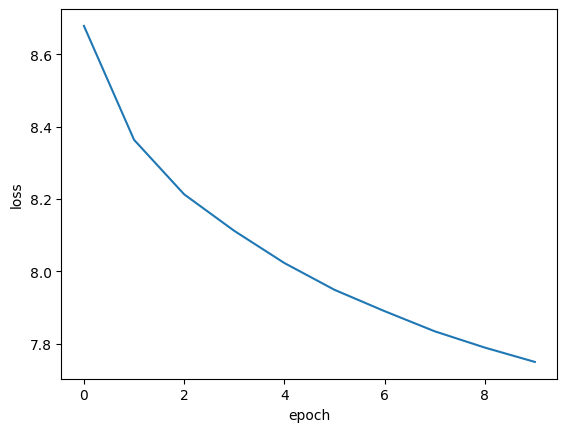

In [75]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## skip-gramモデルの評価
###ここでは学習によって得られた単語ベクトルを用いて、今回のモデルの性能を評価します。次の二つの方法で評価していきます。
- ベクトルの類似度：単語ベクトル同士の類似度を計算して私たちの感覚と合致するか確認します
- 類推問題：king：man = queen：? のような問題が解けるのかを確認します

In [ ]:
# 単語ベクトル
weights = trained_net.state_dict()
in_embeds_weights = weights['embeds_i.weight']
print(in_embeds_weights.shape)

In [69]:
# 評価関数の定義
# 以下のレポジトリを参考にしました
# https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/util.py
import numpy
import torch
import torch.nn.functional as F

def cos_sim(x, y):
  return F.cosine_similarity(x.unsqueeze(0), y.unsqueeze(0)).item()

def most_sim(query, word_to_id, id_to_word, word_matrix, top=5):
  if query not in word_to_id:
    print(f'{query} is not found.')
    return

  print('\n[query]' + query)
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id]

  vocab_size = word_matrix.shape[0]

  # similarity
  similarity = torch.zeros(vocab_size)
  for i in range(vocab_size):
    similarity[i] = cos_sim(word_matrix[i], query_vec)

  # display
  count = 0
  for i in (-1 * similarity).argsort().cpu().numpy():
    if id_to_word[i] == query:
      continue

    print('%s: %s' % (id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return


In [70]:
# 類似度の表示
query = ["you", "year", "car", "toyota"]
for q in query:
  most_sim(q, word_to_id, id_to_word, in_embeds_weights, top=5)


[query]you
your: tensor(0.6185)
someone: tensor(0.6029)
i: tensor(0.5925)
yourself: tensor(0.5856)
if: tensor(0.5657)

[query]year
earlier: tensor(0.6614)
tons: tensor(0.4908)
this: tensor(0.4774)
fiscal: tensor(0.4753)
guilders: tensor(0.4694)

[query]car
cars: tensor(0.6346)
motor: tensor(0.5272)
corsica: tensor(0.5172)
auto: tensor(0.5078)
lexus: tensor(0.4852)

[query]toyota
lexus: tensor(0.6925)
infiniti: tensor(0.6675)
luxury: tensor(0.6477)
corsica: tensor(0.6421)
motor: tensor(0.6327)


In [71]:
# 類推問題
# 以下のレポジトリを参考にしました
# https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/common/util.py

import torch
from typing import Dict

def analogy(a: str, b: str, c: str, word_to_id: Dict[str, int], id_to_word: Dict[int, str], word_matrix: torch.Tensor, top: int = 5, answer: str = None):
  for word in (a, b, c):
    if word not in word_to_id:
      print(f'{word} is not found.')
      return

  print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
  a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
  query_vec = b_vec - a_vec + c_vec
  query_vec = normalize(query_vec)

  # similarity
  similarity = torch.mv(word_matrix, query_vec)

  if answer is not None:
    print('==>' + answer + ':' + str(torch.dot(word_matrix[word_to_id[answer]], query_vec)))

  # display
  count = 0
  for i in (-1 * similarity).argsort().cpu().numpy():
    if torch.isnan(similarity[i]):
      continue

    if id_to_word[i] in (a, b, c):
      continue

    print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return

def normalize(x: torch.Tensor) -> torch.Tensor:
  # テンソルの正規化
  return x / torch.sqrt((x ** 2).sum())

In [72]:
# 類推問題を解く(現状、良い結果は得られませんでした。。。)
analogy('man', 'king', 'woman', word_to_id, id_to_word, in_embeds_weights, top=5)
analogy('take', 'took', 'go', word_to_id, id_to_word, in_embeds_weights, top=5)
analogy('car', 'cars', 'child', word_to_id, id_to_word, in_embeds_weights, top=5)


[analogy] man:king = woman:?
 disease: 1.5116997957229614
 user: 1.41786527633667
 epo: 1.4159584045410156
 rubicam: 1.406980276107788
 print: 1.3894294500350952

[analogy] take:took = go:?
 ran: 1.382978916168213
 bought: 1.3222405910491943
 back: 1.2813529968261719
 kept: 1.225399136543274
 trap: 1.1942774057388306

[analogy] car:cars = child:?
 rape: 2.307985305786133
 incest: 2.041339874267578
 serial: 1.956311821937561
 adults: 1.9404823780059814
 pregnant: 1.8595755100250244


今回は計算リソースの都合、エポックを多めに設定できなかったため良い結果が得られなかったのではないかと考えられます。特に類推問題は、期待した結果からは大きく離れています。